In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import botorch

sns.set(style='whitegrid', font_scale=1.75)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
import torchsort

import sys
sys.path.insert(0, '..')
from experiments.std_bayesopt.helpers import *

In [3]:
obj_fn = lambda x: np.maximum(-0.125 * x ** 2 + 16 * np.sin(x), 0)

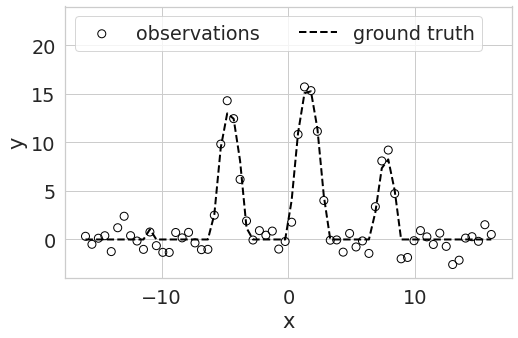

In [4]:
fig = plt.figure(figsize=(8, 5))

noise_scale = 1.
x_bounds = torch.tensor((-16., 16.)).view(-1, 1)

x = np.linspace(*x_bounds, 64)
f = obj_fn(x)
y = f + noise_scale * np.random.randn(*f.shape)

plt.scatter(x, y, edgecolors='black', facecolors='none', label='observations', s=64, zorder=3)
plt.plot(x, f, color='black', linestyle='--', label='ground truth', linewidth=2, zorder=2)

plt.ylabel('y')
plt.xlabel('x')
plt.ylim((-4, 24))
plt.legend(loc='upper left', ncol=2)

In [5]:
import botorch
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import UpperConfidenceBound, ExpectedImprovement
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import IIDNormalSampler

from gpytorch.mlls import ExactMarginalLogLikelihood

from experiments.std_bayesopt.ratio_estimation import RatioEstimator
from experiments.std_bayesopt.utils import assess_coverage, construct_conformal_bands

In [6]:
from lambo.utils import DataSplit, update_splits
from lambo.optimizers.pymoo import Normalizer

cutoff = np.max(np.where(x < -8))
x_min, y_min = x.min(0), y.min(0)
x_range, y_range = x.max(0) - x_min, y.max(0) - y_min

x_norm = Normalizer(
    loc=x_min + 0.5 * x_range,
    scale=x_range / 2.,
)
y_norm = Normalizer(
    loc=y_min + 0.5 * y_range,
    scale=y_range / 2.,
)

train_x = x[:cutoff]
train_y = y[:cutoff]

all_inputs = torch.tensor(x_norm(x), device=DEVICE).view(-1, 1)
all_targets = torch.tensor(y_norm(y), device=DEVICE).view(-1, 1)
target_dim = all_targets.shape[-1]

new_split = DataSplit(
    all_inputs[:cutoff].cpu().numpy(), all_targets[:cutoff].cpu().numpy()
)
train_split, val_split, test_split = update_splits(
    train_split=DataSplit(),
    val_split=DataSplit(),
    test_split=DataSplit(),
    new_split=new_split,
    holdout_ratio=0.2
)

input_bounds = torch.tensor([-1., 1.], device=DEVICE).view(-1, 1)

In [7]:
def run_datashift_opt(splits, seed, acqf="ei", alpha=0.1):
    def draw_plot(ax):
        # plot p(f | x, D)
        ax.plot(all_inputs.cpu(), f_hat_mean, color='blue', linewidth=2, zorder=4, label='p(f | x, D)')
        ax.fill_between(all_inputs.view(-1).cpu(), f_hat_mean - 1.96 * f_hat_std, f_hat_mean + 1.96 * f_hat_std,
                        color='blue', alpha=0.25)
        
        # plot C_\alpha(x)
        ax.fill_between(all_inputs.view(-1).cpu(), conf_lb.view(-1).cpu(), conf_ub.view(-1).cpu(),
                       color='blueviolet', alpha=0.25)

        # plot a(x)
        ax.plot(all_inputs.cpu(), acq_vals, color='green', zorder=5, linewidth=2, label='a(x)')
        ax.scatter(input_query.cpu(), target_query.cpu(), marker='x', color='red', label='x*', zorder=5,
                   s=32, linewidth=2)
        
        #plot r(x)
        if density_ratio is not None:
            ax.plot(all_inputs.cpu(), density_ratio, color='darkorange', zorder=6, linewidth=2, label='r(x)')

        # plot observed
        ax.scatter(train_inputs.cpu(), train_targets.cpu(), edgecolors='black', facecolors='black',
                   label='D', s=32, zorder=3)

        # plot true function
        ax.plot(all_inputs.cpu(), y_norm(f), color='black', linestyle='--', label='f')

        ax.set_ylim((-2., 2.))

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(f't={round_idx}')
        return ax
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    train_split, val_split, test_split = splits
    
    rx_estimator = None
    optimize_callback = None

    if acqf == 'ei':
        acqf_init = lambda gp, best_f: qExpectedImprovement(
            gp,
            best_f=train_targets.max(0)[0],
            sampler=IIDNormalSampler(64)
        )
    elif acqf == "nei":
        acqf_init = lambda gp, best_f: qNoisyExpectedImprovement(
            gp, X_baseline=train_inputs, sampler=IIDNormalSampler(64)
        )
    elif acqf == 'conformal_ei':
        def acqf_init(gp, best_f):
            gp.conformal()
            return qConformalExpectedImprovement(
                gp,
                best_f=train_targets.max(0)[0],
                sampler=PassSampler(32),
                cache_root=False
            )
    elif acqf == "conformal_nei":
        def acqf_init(gp, best_f):
            gp.conformal()
            return qConformalNoisyExpectedImprovement(
                gp,
                X_baseline=train_inputs,
                sampler=PassSampler(32),
                cache_root=False
            )
        
    num_rounds = 32
    plot_interval = 8
    
    output_dict = {
        'f_queries': torch.empty(num_rounds),
        'cred_cvrg': torch.empty(num_rounds),
        'conf_cvrg': torch.empty(num_rounds),
        
    }
    for round_idx in range(num_rounds):
        train_inputs = torch.tensor(train_split[0], device=DEVICE)
        train_targets = torch.tensor(train_split[1], device=DEVICE)
        val_inputs = torch.tensor(
            np.concatenate([val_split[0], test_split[0]]), device=DEVICE
        )
        val_targets = torch.tensor(
            np.concatenate([val_split[1], test_split[1]]), device=DEVICE
        )
        
        # prepare ratio estimator
#         if acqf.startswith('conformal'):
#             rx_estimator = RatioEstimator(in_size=train_split.inputs.shape[-1]).to(DEVICE)
#             optimize_callback = rx_estimator.optimize_callback
#             rx_estimator.dataset._update_splits(
#                 DataSplit(train_inputs.view(-1, 1).cpu(), torch.ones(train_inputs.size(0), 1))
#             )

        matern_gp = ConformalSingleTaskGP(
            train_X=train_inputs,
            train_Y=train_targets,
            alpha=alpha,
            tgt_grid_res=32,
            conformal_bounds=torch.tensor([[-2., 2.]]).t(),
            ratio_estimator=rx_estimator,
        ).to(DEVICE)
        mll = ExactMarginalLogLikelihood(matern_gp.likelihood, matern_gp)
        fit_gpytorch_model(mll)
        # acq_fn = UpperConfidenceBound(matern_gp, beta=8.)
        # HERE WE USE EI
        # acq_fn = ExpectedImprovement(matern_gp, best_f=train_targets.max())
        acq_fn = acqf_init(matern_gp, train_targets.max())
        
        input_query = optimize_acqf(acq_fn, input_bounds, 1, num_restarts=1, raw_samples=2,
                                    options=dict(callback=optimize_callback, disp=False, ftol=1e-12))[0]
        x_query = x_norm.inv_transform(input_query.cpu().numpy())
        f_query = obj_fn(x_query)
        y_query = f_query + noise_scale * np.random.randn(*f_query.shape)
        target_query = torch.tensor(y_norm(y_query), device=DEVICE)
        
        matern_gp.requires_grad_(False)
        matern_gp.eval()
        with torch.no_grad():
            f_hat_dist = matern_gp(all_inputs)
            y_hat_dist = matern_gp.likelihood(f_hat_dist)
            f_hat_mean = f_hat_dist.mean.cpu()
            f_hat_std = f_hat_dist.variance.sqrt().cpu()
            y_hat_mean = f_hat_mean.cpu()
            y_hat_std = y_hat_dist.variance.sqrt().cpu()
            acq_vals = acq_fn(all_inputs[:, None]).cpu()
            conf_lb, conf_ub = construct_conformal_bands(matern_gp, all_inputs, alpha)
            cred_cvrg, conf_cvrg = assess_coverage(matern_gp, val_inputs, val_targets, alpha)
        
        output_dict['f_queries'][round_idx] = y_norm(f_query).item()
        output_dict['cred_cvrg'][round_idx] = cred_cvrg
        output_dict['conf_cvrg'][round_idx] = conf_cvrg
        
        density_ratio = None
        if rx_estimator is not None:
            density_ratio = rx_estimator(all_inputs).cpu()
            density_ratio /= density_ratio.sum()

        new_split = DataSplit(
            input_query.reshape(-1, 1).cpu(),
            target_query.reshape(-1, 1).cpu(),
        )
        train_split, val_split, test_split = update_splits(
            train_split, val_split, test_split, new_split, holdout_ratio=0.2
        )
#         if acqf.startswith('conformal'):
#             rx_estimator.dataset._update_splits(
#                 DataSplit(input_query.reshape(-1, 1).cpu(), torch.ones(1, 1)))

        if round_idx % plot_interval == 0:
            print(f'{train_split[0].shape[0]} train, {val_split[0].shape[0]} val, {test_split[0].shape[0]} test')
            if rx_estimator is not None:
                print(f'[Iterates] {rx_estimator.dataset.cls_train_split[0].shape[0]} train, {rx_estimator.dataset.cls_val_split[0].shape[0]} val, {rx_estimator.dataset.cls_test_split[0].shape[0]} test')
            fig = plt.figure(figsize=(8, 5))
            ax = fig.add_subplot(1, 1, 1)
            draw_plot(ax)

    plt.show()

    return output_dict

### Global settings

In [8]:
alpha = 0.05  # acceptable miscoverage level
num_trials = 4

11 train, 2 val, 3 test
15 train, 4 val, 5 test
23 train, 4 val, 5 test
29 train, 4 val, 7 test


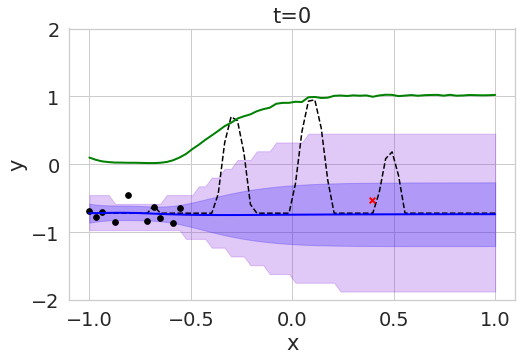

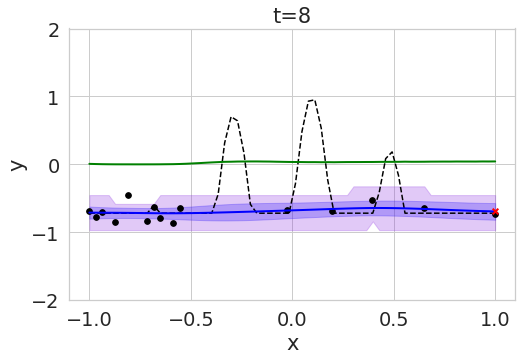

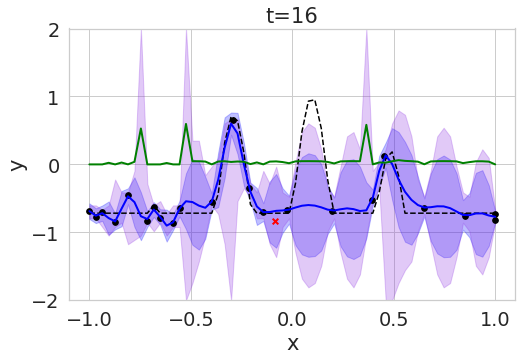

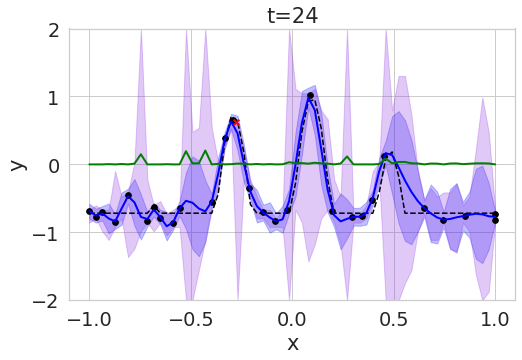

11 train, 2 val, 3 test
17 train, 3 val, 4 test
23 train, 4 val, 5 test
29 train, 4 val, 7 test


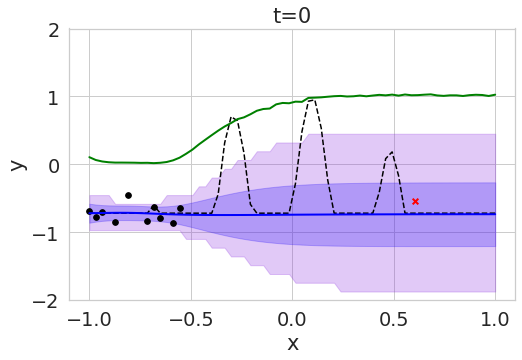

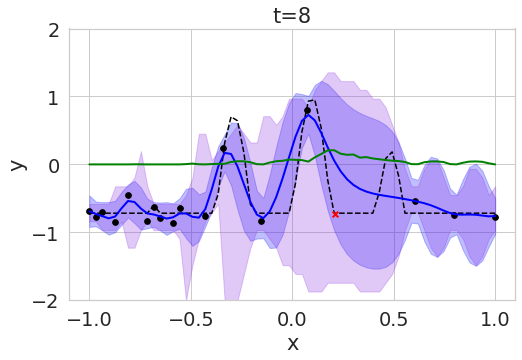

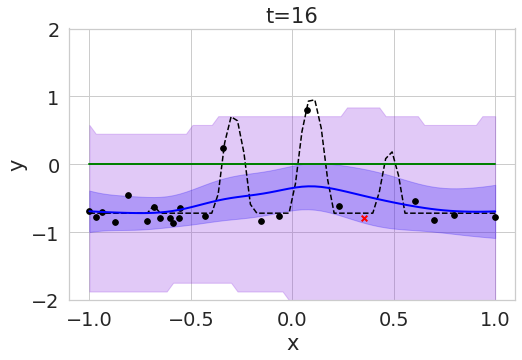

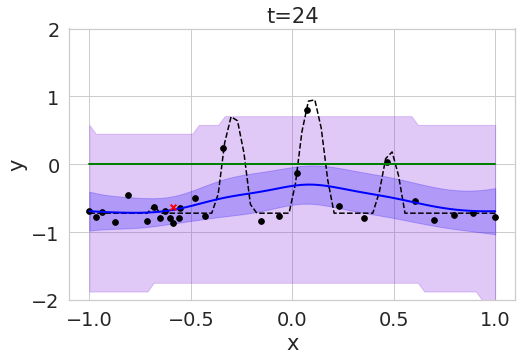

11 train, 2 val, 3 test
17 train, 3 val, 4 test
22 train, 5 val, 5 test
29 train, 5 val, 6 test


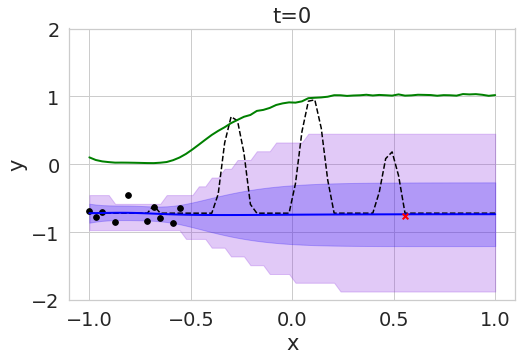

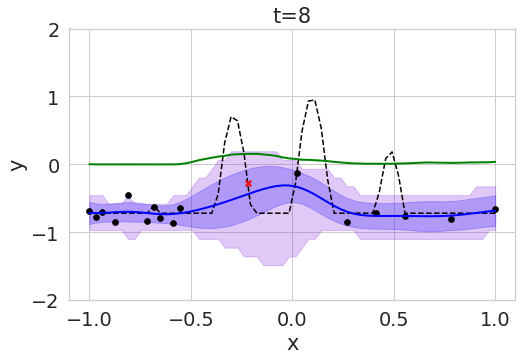

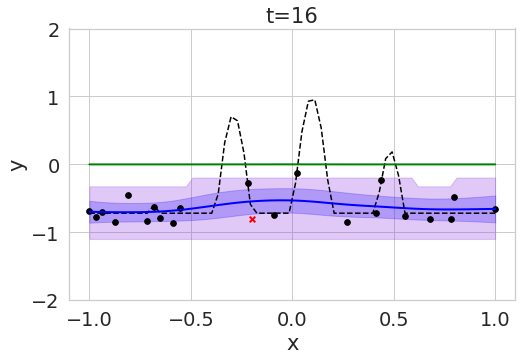

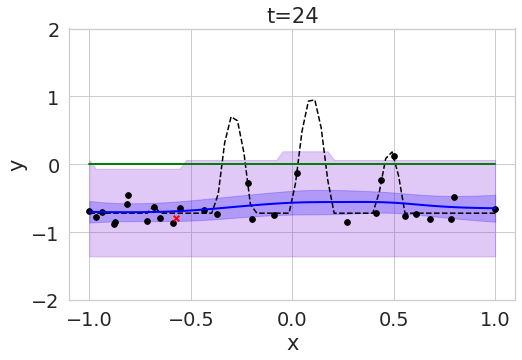

11 train, 2 val, 3 test
18 train, 3 val, 3 test
24 train, 5 val, 3 test
29 train, 6 val, 5 test


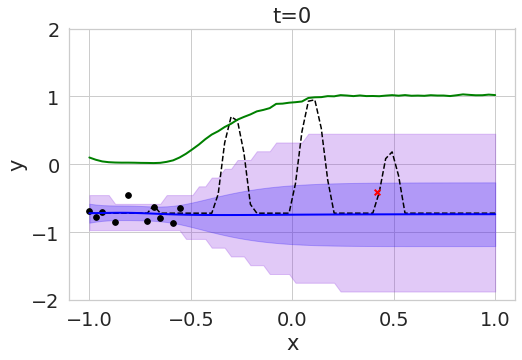

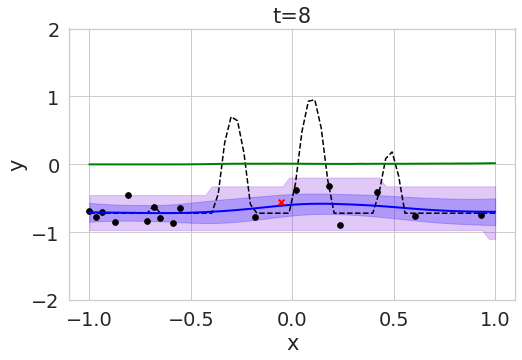

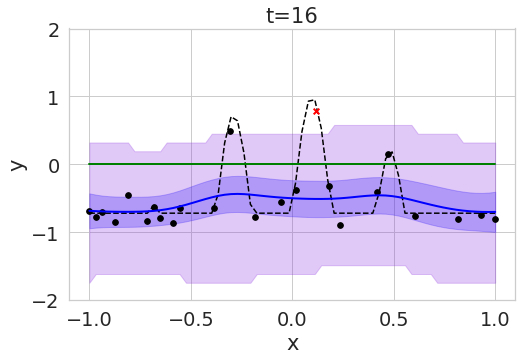

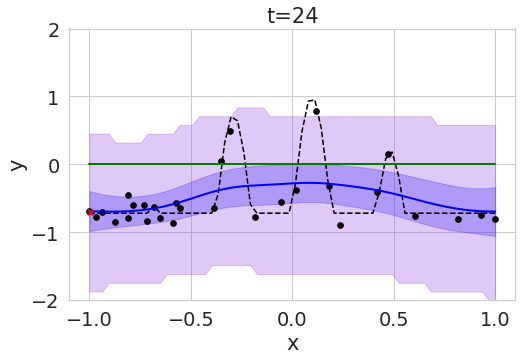

In [9]:
conformal_out = [
    run_datashift_opt(
        [train_split, val_split, test_split], seed, acqf="conformal_ei", alpha=alpha
    ) for seed in range(num_trials)
]

11 train, 2 val, 3 test
15 train, 4 val, 5 test
23 train, 4 val, 5 test
29 train, 4 val, 7 test


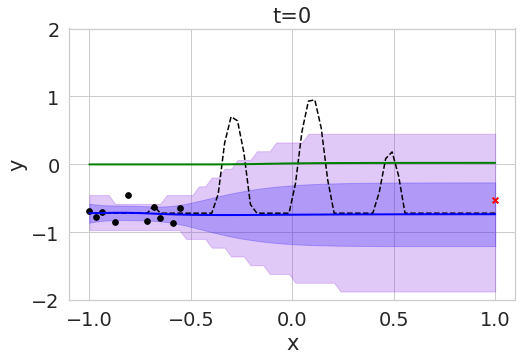

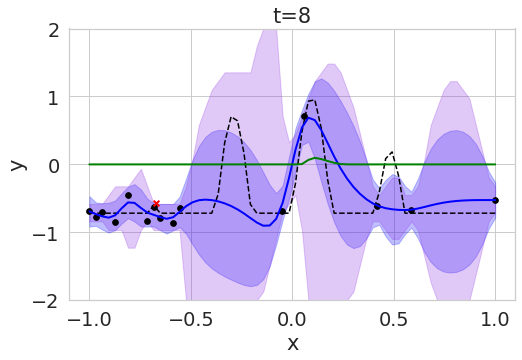

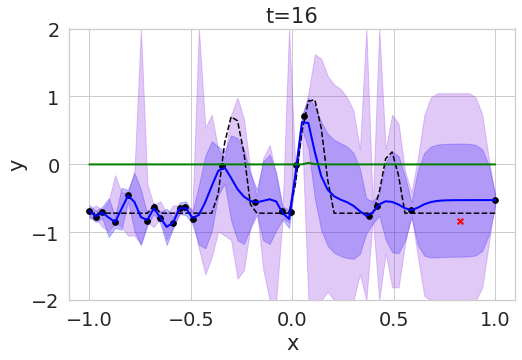

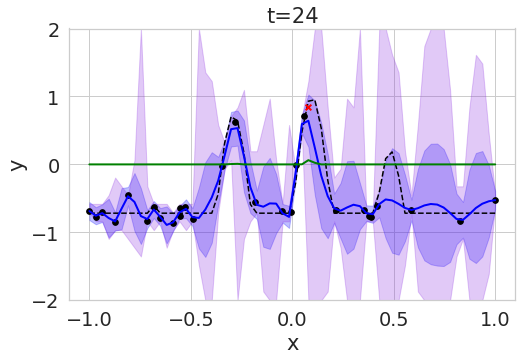

11 train, 2 val, 3 test
17 train, 3 val, 4 test
23 train, 4 val, 5 test
29 train, 4 val, 7 test


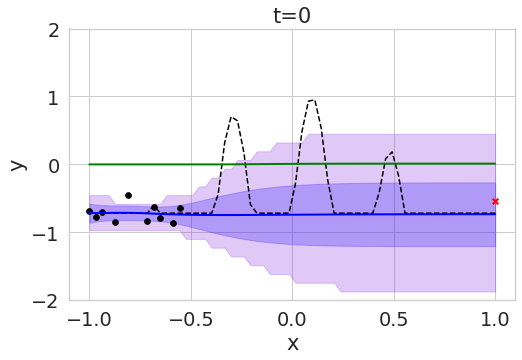

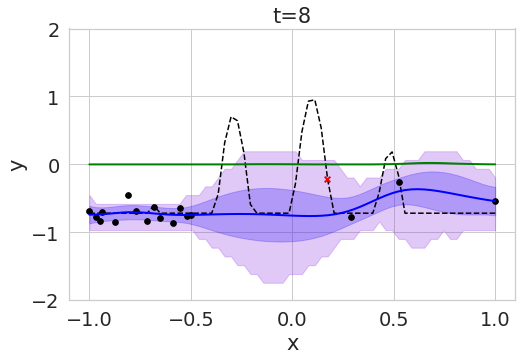

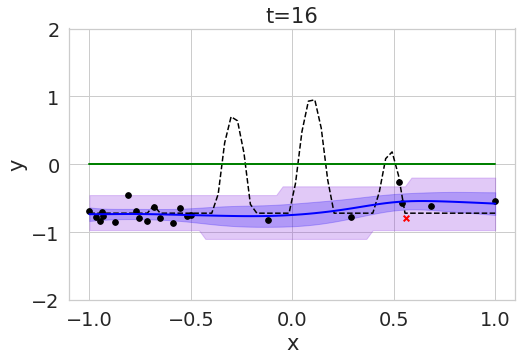

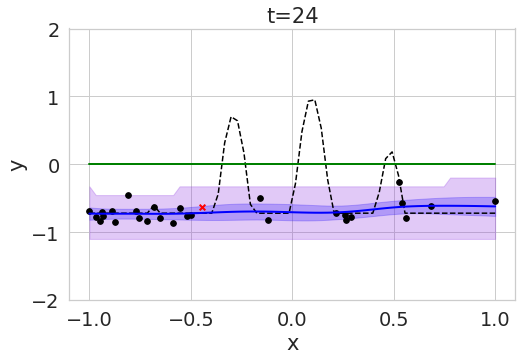

11 train, 2 val, 3 test
17 train, 3 val, 4 test
22 train, 5 val, 5 test
29 train, 5 val, 6 test


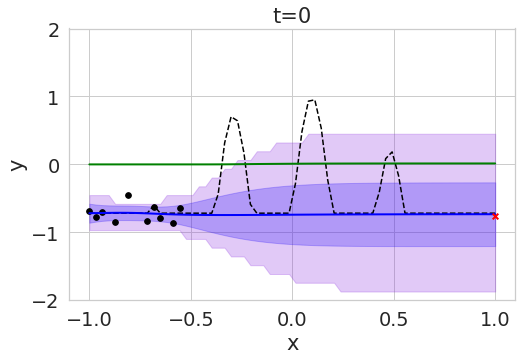

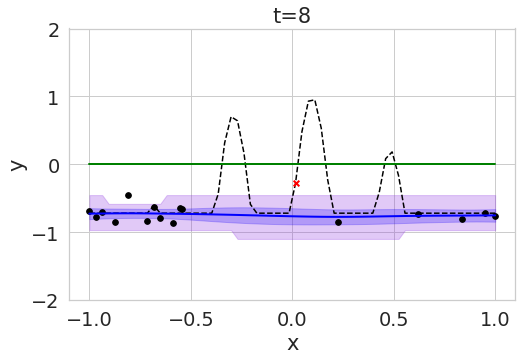

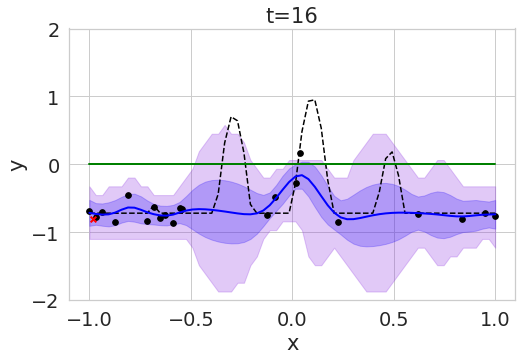

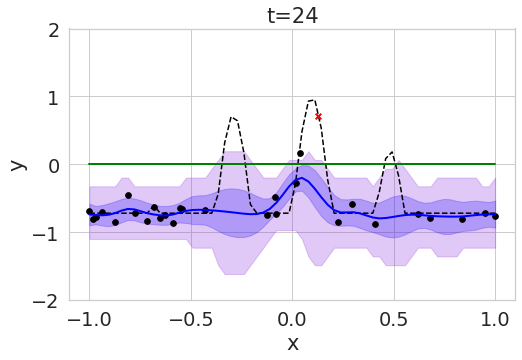

11 train, 2 val, 3 test
18 train, 3 val, 3 test
24 train, 5 val, 3 test
29 train, 6 val, 5 test


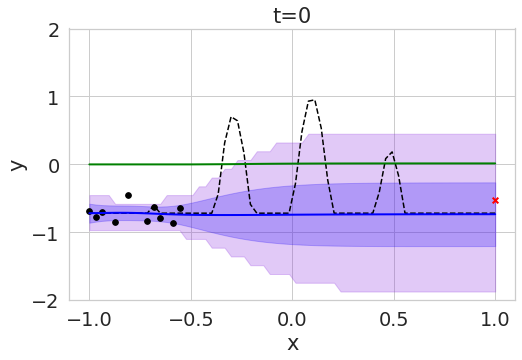

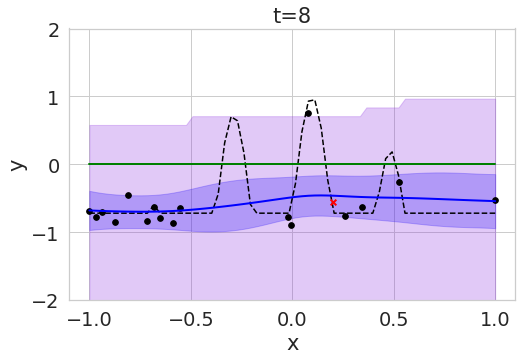

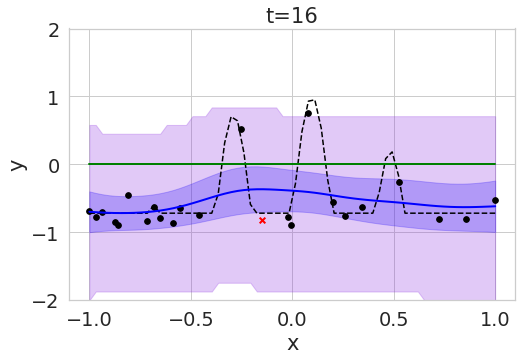

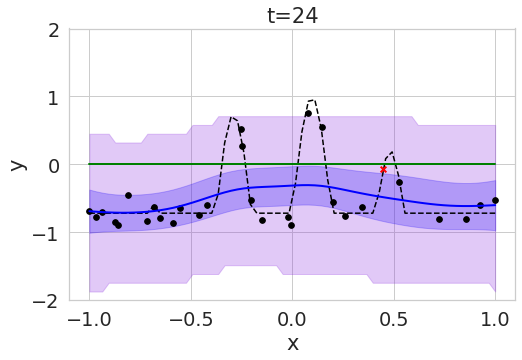

In [10]:
std_out = [
    run_datashift_opt(
        [train_split, val_split, test_split], seed, acqf="ei", alpha=alpha
    ) for seed in range(num_trials)
]

Text(0, 0.5, 'Best $f$ Achieved')

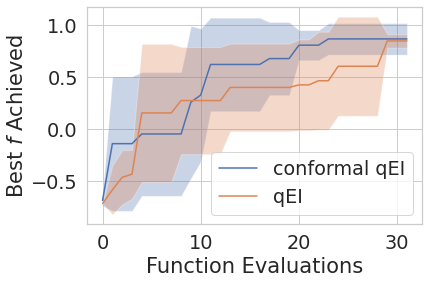

In [11]:
conf_best_f = torch.stack([d['f_queries'] for d in conformal_out]).cummax(1)[0]
std_best_f = torch.stack([d['f_queries'] for d in std_out]).cummax(1)[0]

plt.plot(conf_best_f.mean(0), label = "conformal qEI")
plt.fill_between(torch.arange(conf_best_f.size(-1)), 
                 conf_best_f.mean(0) - 2. / 5**0.5 * conf_best_f.std(0), 
                 conf_best_f.mean(0) + 2. / 5**0.5 * conf_best_f.std(0), 
                 alpha = 0.3)
plt.plot(std_best_f.mean(0), label = "qEI")
plt.fill_between(torch.arange(std_best_f.size(-1)), 
                 std_best_f.mean(0) - 2. / 5**0.5 * std_best_f.std(0), 
                 std_best_f.mean(0) + 2. / 5**0.5 * std_best_f.std(0), 
                 alpha = 0.3)
plt.legend()
plt.xlabel("Function Evaluations")
plt.ylabel(r"Best $f$ Achieved")

Text(0, 0.5, 'Empirical Coverage')

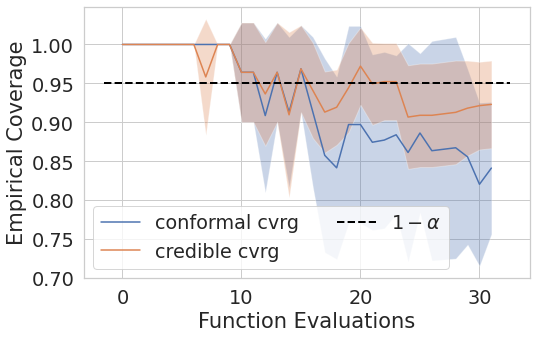

In [12]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

conf_cvrg = torch.stack([d['conf_cvrg'] for d in conformal_out])
cred_cvrg = torch.stack([d['cred_cvrg'] for d in conformal_out])

plt.plot(conf_cvrg.mean(0), label = "conformal cvrg")
plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
                 conf_cvrg.mean(0) - 2. / 5**0.5 * conf_cvrg.std(0), 
                 conf_cvrg.mean(0) + 2. / 5**0.5 * conf_cvrg.std(0), 
                 alpha = 0.3)
plt.plot(cred_cvrg.mean(0), label = "credible cvrg")
plt.fill_between(torch.arange(conf_cvrg.size(-1)), 
                 cred_cvrg.mean(0) - 2. / 5**0.5 * cred_cvrg.std(0), 
                 cred_cvrg.mean(0) + 2. / 5**0.5 * cred_cvrg.std(0), 
                 alpha = 0.3)

plt.hlines(1 - alpha, *plt.xlim(), color='black', linestyle='--', linewidth=2, label=r'$1 - \alpha$')

plt.legend(ncol=2)
plt.xlabel("Function Evaluations")
plt.ylabel("Empirical Coverage")